In [1]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

## Create Simulated Data ##

Instead of using clustered cells, we can directly decode position from the multiunit spikes and the associated spike waveform features that would normally be used to cluster them. Here we demonstrate on some simulated data, where we mimic recording from tetrodes (four wires) and collect the max amplitude of the spike waveform feature at the time of the spike. So we have four spike amplitudes and position.

In [2]:
from replay_trajectory_classification.clusterless_simulation import make_simulated_run_data

(time, position, sampling_frequency,
 multiunits, multiunits_spikes) = make_simulated_run_data()

First we plot the position at each time and the multiunit spikes and associated waveform features.

(0.0, 349.999)

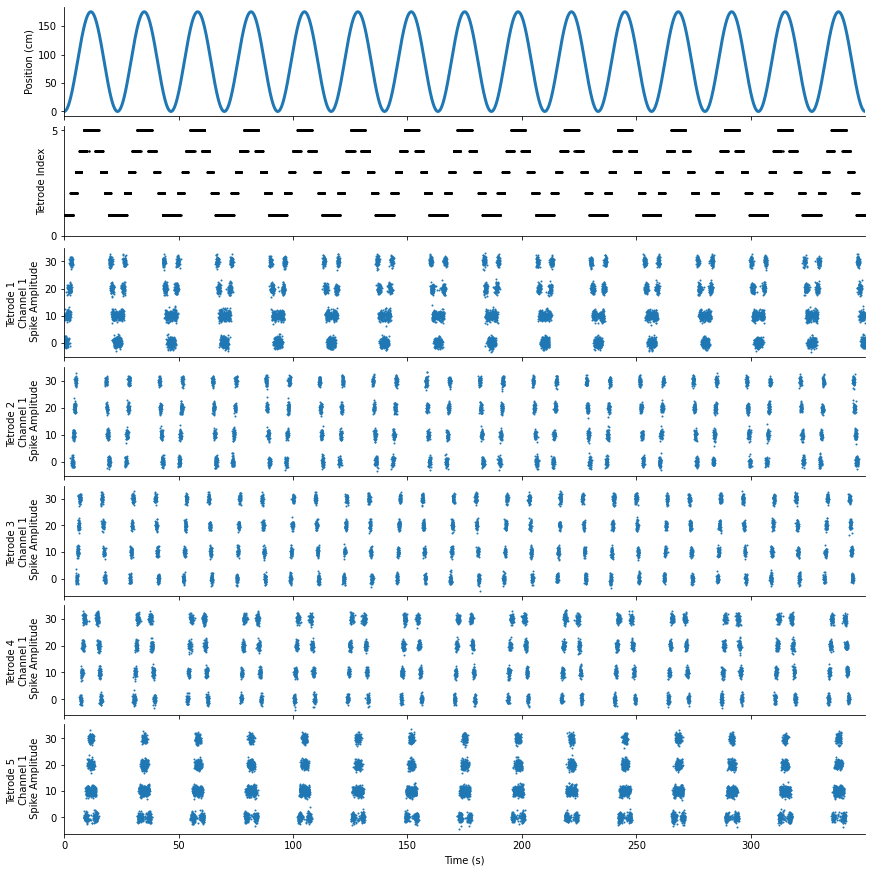

In [3]:
spike_ind, neuron_ind = np.nonzero(multiunits_spikes)

fig, axes = plt.subplots(7, 1, figsize=(12, 12), constrained_layout=True, sharex=True)
axes[0].plot(time, position, linewidth=3)
axes[0].set_ylabel('Position (cm)')

axes[1].scatter(time[spike_ind], neuron_ind + 1, color='black', s=2)
axes[1].set_yticks((0, multiunits_spikes.shape[1]))
axes[1].set_ylabel('Tetrode Index')

for tetrode_ind in range(multiunits.shape[-1]):
    axes[2 + tetrode_ind].scatter(time, multiunits[:, 0, tetrode_ind], s=1)
    axes[2 + tetrode_ind].set_ylabel(f'Tetrode {tetrode_ind + 1} \n Channel 1 \n Spike Amplitude')

sns.despine()
axes[-1].set_xlabel('Time (s)')
axes[-1].set_xlim((time.min(), time.max()))

We can also plot the spike waveform features against each other, instead of over time. From this we can see that there are four simulated cells on the first tetrode.

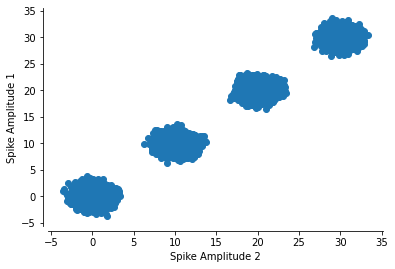

In [4]:
plt.scatter(multiunits[:, 0, 0], multiunits[:, 1, 0])
plt.ylabel('Spike Amplitude 1')
plt.xlabel('Spike Amplitude 2')
sns.despine(offset=5)

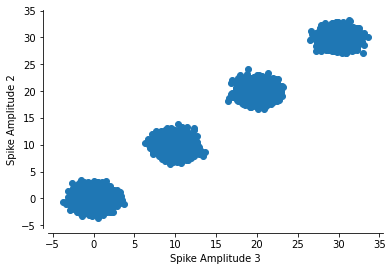

In [5]:
plt.scatter(multiunits[:, 1, 0], multiunits[:, 2, 0])
plt.ylabel('Spike Amplitude 2')
plt.xlabel('Spike Amplitude 3')
sns.despine(offset=5)

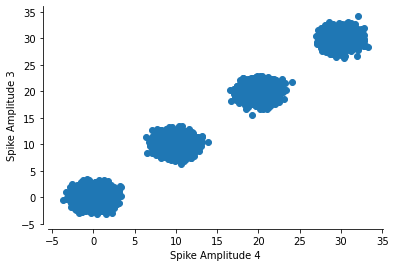

In [6]:
plt.scatter(multiunits[:, 2, 0], multiunits[:, 3, 0])
plt.ylabel('Spike Amplitude 3')
plt.xlabel('Spike Amplitude 4')
sns.despine(offset=5)

### Fitting ###

So we have four spike amplitudes and position. Our goal is to fit an encoding model that relates these amplitudes to position. The setup here is much the same as the `SortedSpikesDecoder`. We initialize the decoder with some parameters and tehn we fit the position and multiunits. We are again using the estimated movement variance from the animal's position to set the variance of the random walk (`movement_var`). We also set the size of the place bins (`place_bin_size`) to be the square root of the estimated movement variance so that it corresponds to one standard deviation of the Gaussian for the random walk.

An **important** parameter here---different from the `SortedSpikesDecoder` is the 'bandwidth' parameter. This is passed as a parameter in the model keyword arguments. The bandwidth is a vector that sets the amount of smoothing done for the kernel density estimates for both the spike waveform features and position. Position always occupies the last one or two dimensions.

So for our case, we have a five dimensiononal vector. THe first four dimensions correspond to the bandwidth parameter for the spike amplitudes. The last dimension corresponds to our 1D position.

**NOTE**: These particular bandwith parameters are not the ones typically used with real data. A bandwidth of 24 would be more common for this particular dimension. Likewise, we are using a slightly larger position bandwith. A more typical one would be 6.

In [7]:
from replay_trajectory_classification import ClusterlessDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk
from replay_trajectory_classification.misc import NumbaKDE

movement_var = estimate_movement_var(position, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
transition_type = RandomWalk(movement_var=movement_var)

## If your marks are floats, use this algorithm
# clusterless_algorithm = 'multiunit_likelihood'
# clusterless_algorithm_params = {
#     'model': NumbaKDE,
#     'model_kwargs': {
#          'bandwidth': np.array([1.0, 1.0, 1.0, 1.0, 12.5]) # amplitude 1, amplitude 2, amplitude 3, amplitude 4, position       
#     }
# }

# If your marks are integers, use this algorithm because it is much faster
clusterless_algorithm = 'multiunit_likelihood_integer'
clusterless_algorithm_params = {
    'mark_std': 1.0,
    'position_std': 12.5,
}
    

decoder = ClusterlessDecoder(
    environment=environment,
    transition_type=transition_type,
    clusterless_algorithm=clusterless_algorithm,
    clusterless_algorithm_params=clusterless_algorithm_params)
decoder.fit(position, multiunits)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting multiunits...


ClusterlessDecoder(clusterless_algorithm='multiunit_likelihood_integer',
                   clusterless_algorithm_params={'mark_std': 1.0,
                                                 'position_std': 12.5},
                   environment=Environment(environment_name='', place_bin_size=0.526862608560107, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True),
                   infer_track_interior=True,
                   initial_conditions_type=UniformInitialConditions(),
                   transition_type=RandomWalk(environment_name='', movement_var=0.2775842082987605, movement_mean=0.0))

## Predicting Position ##

Once we have fit the model, we can predict position from the multiunit spikes and their associated waveforms.

Note here that the decoding here will probably take much longer than the `SortedSpikesDecoder`.

In [8]:
time_ind = slice(0, 50000)

results = decoder.predict(multiunits[time_ind], time=time[time_ind])
results

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...


<xarray.Dataset>
Dimensions:            (time: 50000, position: 333)
Coordinates:
  * time               (time) float64 0.0 0.001 0.002 0.003 ... 50.0 50.0 50.0
  * position           (position) float64 0.2628 0.7883 1.314 ... 174.2 174.7
Data variables:
    likelihood         (time, position) float64 1.0 0.9999 ... 0.9543 0.9537
    causal_posterior   (time, position) float64 0.00304 0.00304 ... 2.693e-154
    acausal_posterior  (time, position) float64 0.07233 0.09579 ... 2.693e-154

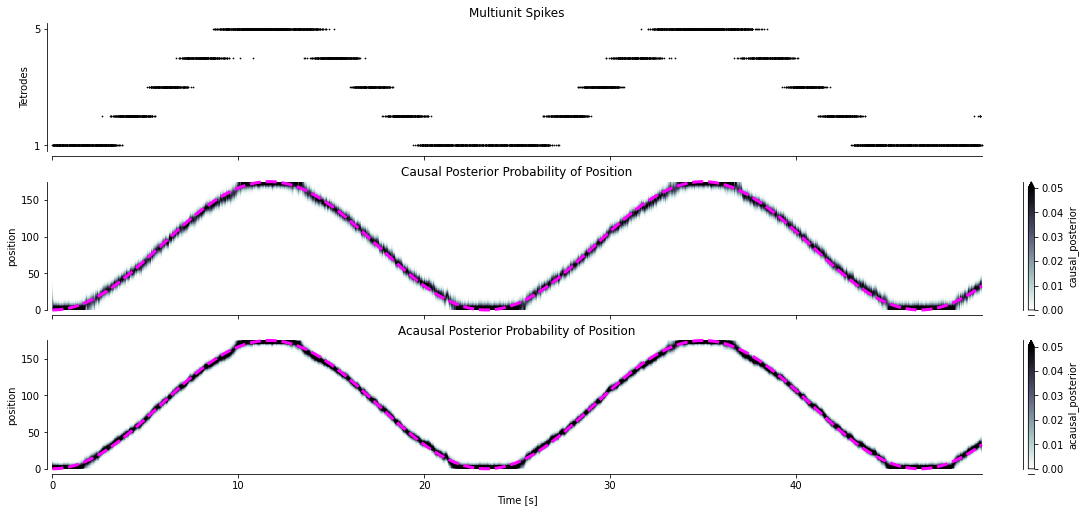

In [9]:
fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15, 7))

spike_ind, neuron_ind = np.nonzero(multiunits_spikes[time_ind])
axes[0].scatter(time[spike_ind], neuron_ind + 1, c="black", s=0.5, clip_on=False)
axes[0].set_yticks((1, multiunits_spikes.shape[1]))
axes[0].set_ylabel('Tetrodes')
axes[0].set_title("Multiunit Spikes")

results.causal_posterior.plot(x="time", y="position", ax=axes[1], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[1].plot(time[time_ind], position[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[1].set_xlabel("")
axes[1].set_title("Causal Posterior Probability of Position")
results.acausal_posterior.plot(x="time", y="position", ax=axes[2], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[2].plot(time[time_ind], position[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[2].set_title("Acausal Posterior Probability of Position")
axes[2].set_xlabel('Time [s]')
sns.despine(offset=5)

`results` has three main variables:
+ **likelihood** -- the probablility of spikes given position
+ **causal_posterior**: the probability of position given only past spikes
+ **acausal_posterior**: the probability of position given all past and future spikes

You'll probably want to use the **acausal_posterior**, but we can visualize both the acausal and causal and overlay the true position (magenta dashed line):

From this, we can see, as expected, that the decoded position (given as a probability of position over time) matches the true position well.